In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(iterations=100, verbose=10)
#cb.fit(X, y, cat_features = cat_features, verbose = False)

In [4]:
data = pd.read_csv('../../Data/Ten_scaled.csv')

In [5]:
data.head(5)

,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,term,grade,emp_length,Not Verified,Source Verified,Verified,loan_status_bin
0,-1.257328,0.158569,-1.218923,-0.322166,-1.276775,-0.667208,-0.571945,0.197404,1.092907,1.499675,-0.815693,-0.643276,0.0
1,1.156136,-0.260761,1.437802,-0.181486,-0.216161,0.596113,-0.571945,0.197404,1.092907,1.499675,-0.815693,-0.643276,0.0
2,0.618540,-0.514455,-0.039143,-0.209622,-0.767889,-0.035548,1.748420,-0.573732,1.092907,1.499675,-0.815693,-0.643276,0.0
3,-0.479529,1.932333,-0.583062,0.373261,0.756678,-0.035548,1.748420,2.510810,-0.803529,-0.666811,1.225952,-0.643276,0.0
4,-0.302237,0.043253,-0.143850,-0.617596,-0.828496,-0.193463,-0.571945,0.197404,-0.532609,-0.666811,1.225952,-0.643276,0.0


In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(1266782, 12)

In [7]:
y = data['loan_status_bin']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [9]:
cb.fit(X_train, y_train, verbose=10)

Learning rate set to 0.5
0:	learn: 0.5347104	total: 90.2ms	remaining: 8.93s
10:	learn: 0.4495729	total: 322ms	remaining: 2.61s
20:	learn: 0.4485718	total: 559ms	remaining: 2.1s
30:	learn: 0.4478185	total: 780ms	remaining: 1.74s
40:	learn: 0.4472226	total: 1.02s	remaining: 1.47s
50:	learn: 0.4466473	total: 1.32s	remaining: 1.27s
60:	learn: 0.4461966	total: 1.57s	remaining: 1s
70:	learn: 0.4457172	total: 1.83s	remaining: 748ms
80:	learn: 0.4453618	total: 2.07s	remaining: 486ms
90:	learn: 0.4449831	total: 2.33s	remaining: 231ms
99:	learn: 0.4447253	total: 2.56s	remaining: 0us


In [10]:
cb.score(X_test, y_test)

0.8064441433025905

In [11]:
from sklearn.metrics import confusion_matrix
y_pred = cb.predict(X_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[302150,   3657],
       [ 69901,   4327]])

In [16]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

In [17]:
TP  #We want to increast TP, our ability to predict loans that will "default"

4327

In [21]:
FP

3657

In [22]:
FN

69901

In [23]:
TN

302150

In [24]:
TPR = TP / (TP + FN)
TPR

0.05829336638465269

In [25]:
TNR = TN / (TN + FP)
TNR

0.988041477140811

In [26]:
Precision = TP / (TP + FP)
Precision

0.5419589178356713

In [27]:
Recall = TP / (TP + FN)       # We want a high "recall" because we want to reduce FN, or predict loans 
Recall                        # that were charged off as "fully paid". Expensive to investor.   

0.05829336638465269

In [28]:
data['loan_status_bin'].value_counts()*0.3

#305,806 loans fully paid on test set
#74,227 loans charged off on test set

0.0    305806.8
1.0     74227.8
Name: loan_status_bin, dtype: float64

In [29]:
confusion_matrix_full = pd.DataFrame(cm,
                                     index=["Actual_Fully_Paid","Actual_Charged_Off"],
                                     columns=["Predicted_Fully_Paid","Predicted_Charged_Off"])

confusion_matrix_full

,Predicted_Fully_Paid,Predicted_Charged_Off
Actual_Fully_Paid,302150,3657
Actual_Charged_Off,69901,4327


In [30]:
X.columns

Index(['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'fico_range_low', 'term', 'grade', 'emp_length', 'Not Verified',
       'Source Verified', 'Verified'],
      dtype='object')

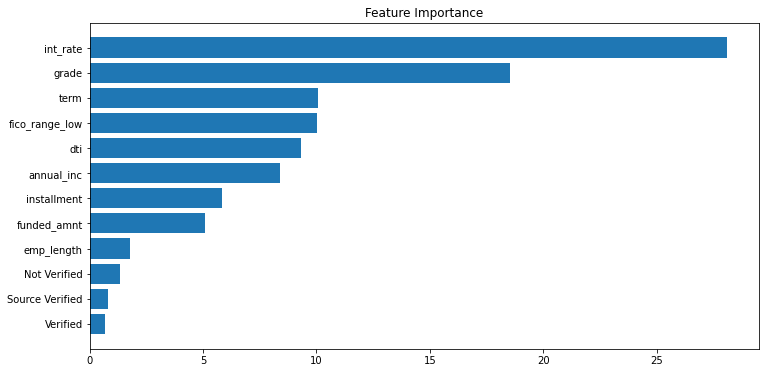

In [31]:
import matplotlib.pyplot as plt

feature_importance = cb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

In [16]:
import shap

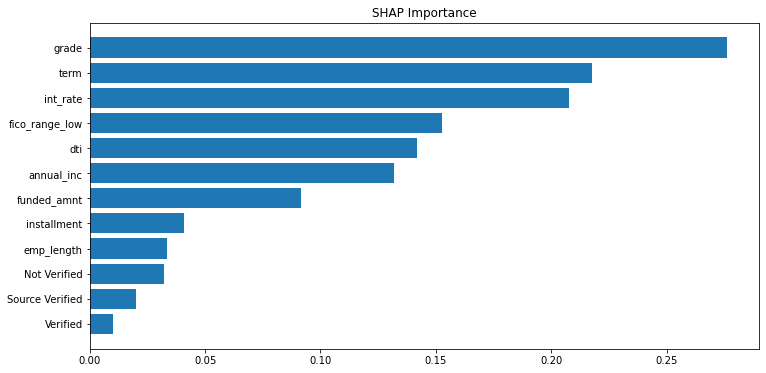

In [17]:
explainer = shap.Explainer(cb)
shap_values = explainer(X_test)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance');

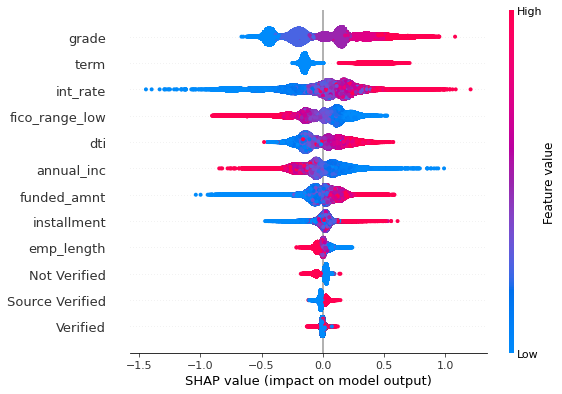

In [18]:
shap.summary_plot(shap_values, max_display=X_test.shape[0])